### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import MetaTrader5 as mt5
from MetaTrader5 import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras import layers, Sequential, Input, models
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
%matplotlib inline

### Retrieving Data from MT5

In [2]:
# Creating a dictonary for storing all the credentials for MT5
credentials = {
    "login": 51840772,
    "password": "@Hb$KDlLZ8CvJe",
    "server": "ICMarketsSC-Demo",
    "path": "C:/Program Files/MetaTrader 5/terminal64.exe",
    "timeout": 60000,
    "portable": False 
}

# Connecting to MT5 using the credentials above
if mt5.initialize(path=credentials['path'],
                  login=credentials['login'],
                  password=credentials['password'],
                  server=credentials['server'],
                  timeout=credentials['timeout'],
                  portable=credentials['portable']):
    
    print("Plataform MT5 launched correctly")
else:
    print(f"There has been a problem with initialization: {mt5.last_error()}")

Plataform MT5 launched correctly


In [3]:
# Assigning some variables to pass in the mt5.copy_rates_range function
symbol = "BTCUSD" # Data of Interest
timeframe = mt5.TIMEFRAME_M15 # 15-minute intervals
date_from = datetime(2021, 12, 12)
date_to = datetime.now()

prices = mt5.copy_rates_range(symbol, timeframe, date_from, date_to)
prices_df = pd.DataFrame(prices)

# Converting the 'time' column to datetime format using seconds as the unit
prices_df["time"] = pd.to_datetime(prices["time"], unit="s")

In [4]:
prices_df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,2021-12-12 00:00:00,48811.49,48825.08,48707.28,48779.88,280,1192,0
1,2021-12-12 00:15:00,48779.88,48799.52,48668.32,48743.47,282,1090,0
2,2021-12-12 00:30:00,48743.97,49133.91,48739.47,49004.91,420,1090,0
3,2021-12-12 00:45:00,49004.91,49004.91,48828.98,48828.98,541,2827,0
4,2021-12-12 01:00:00,48828.98,49380.57,48789.65,49220.57,526,1090,0


In [5]:
# Setting time column as the index for plotting graph
prices_df.set_index('time', inplace=True)
prices_df.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2021-12-12 00:00:00,48811.49,48825.08,48707.28,48779.88,280,1192,0
2021-12-12 00:15:00,48779.88,48799.52,48668.32,48743.47,282,1090,0
2021-12-12 00:30:00,48743.97,49133.91,48739.47,49004.91,420,1090,0
2021-12-12 00:45:00,49004.91,49004.91,48828.98,48828.98,541,2827,0
2021-12-12 01:00:00,48828.98,49380.57,48789.65,49220.57,526,1090,0


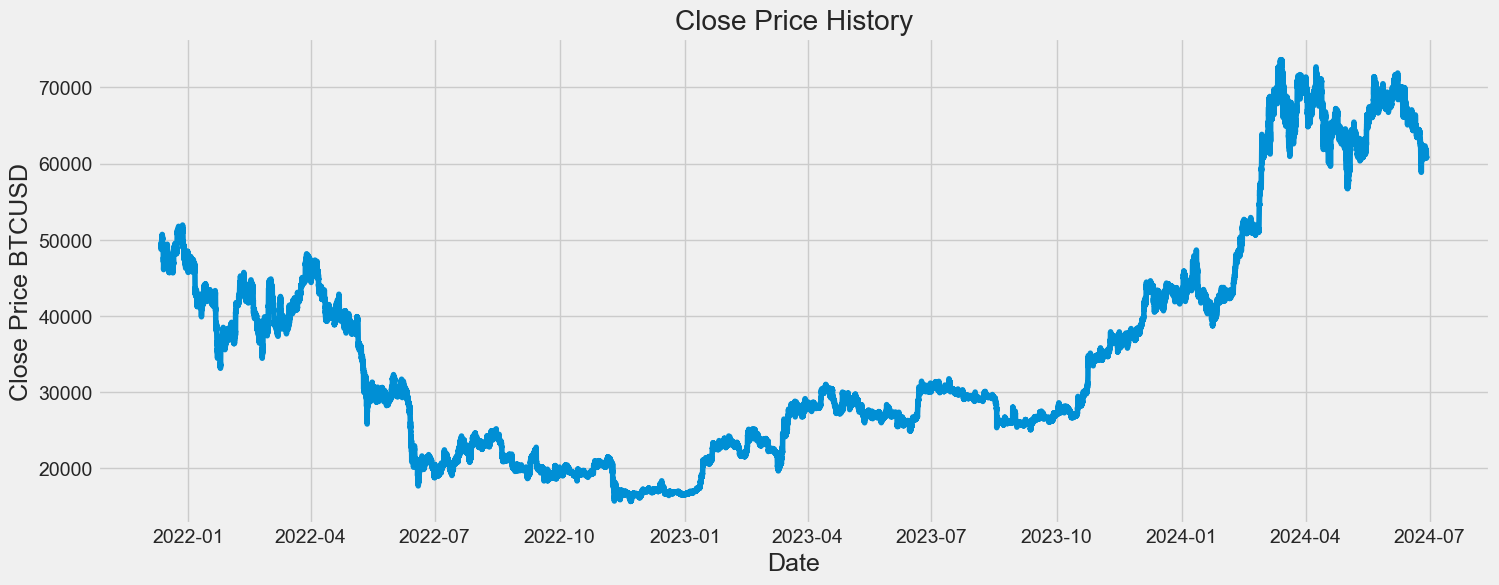

In [6]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(prices_df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price BTCUSD', fontsize=18)
plt.show()

### Data Splitting for Model Training

In [7]:
# Creating a new dataframe with only the 'close column'
data = prices_df.filter(["close"])
# Converting the dataframe to a numpy array
dataset = data.values
# Getting the number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * 0.95))
training_data_len

83686

In [8]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.57165189],
       [0.5710247 ],
       [0.57552824],
       ...,
       [0.78089073],
       [0.77949285],
       [0.77669243]])

In [9]:
# Creating training dataset
train_data = scaled_data[0:int(training_data_len), :]
# Splitting the data into x_train and y_train datasets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
# Converting the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
# Reshaping the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

[array([0.57165189, 0.5710247 , 0.57552824, 0.57249768, 0.57924317,
       0.58179571, 0.57996098, 0.58256829, 0.58349211, 0.58600675,
       0.58188166, 0.5813549 , 0.58230422, 0.57951948, 0.5801465 ,
       0.57888987, 0.57846353, 0.5792697 , 0.58124965, 0.57669064,
       0.57770146, 0.57849299, 0.58159055, 0.58103691, 0.57826302,
       0.57970448, 0.57734264, 0.57367594, 0.57606861, 0.57524418,
       0.57582917, 0.57529672, 0.57702327, 0.57605311, 0.57813624,
       0.57868454, 0.57798672, 0.58093958, 0.58122829, 0.5812431 ,
       0.58164136, 0.57917306, 0.57678245, 0.57527381, 0.57481767,
       0.57664017, 0.57479562, 0.5726777 , 0.57148945, 0.57382718,
       0.57280034, 0.57450881, 0.57433741, 0.57601315, 0.5801167 ,
       0.57794382, 0.58206495, 0.58557231, 0.5841088 , 0.58463987])]
[0.5882085635789764]

[array([0.57165189, 0.5710247 , 0.57552824, 0.57249768, 0.57924317,
       0.58179571, 0.57996098, 0.58256829, 0.58349211, 0.58600675,
       0.58188166, 0.5813549 , 0.582

(83626, 60, 1)

### Model Creation

In [10]:
# Initializing the Sequential model
model = Sequential()

# Adding an input layer with the shape of the training data
model.add(Input(shape=(x_train.shape[1], 1)))

# Adding the first LSTM layer with 128 units, setting return_sequences to True to stack another LSTM layer
model.add(layers.LSTM(128, return_sequences=True))

# Adding the second LSTM layer with 64 units, setting return_sequences to False as this is the last LSTM layer
model.add(layers.LSTM(64, return_sequences=False))

# Adding a Dense layer with 25 units
model.add(layers.Dense(25))

# Adding the output Dense layer with 1 unit (for regression output)
model.add(layers.Dense(1))

# Compiling the model with Adam optimizer and mean squared error loss function
model.compile(optimizer="adam", loss="mean_squared_error")

# Training the model on the training data with a batch size of 64 and for 100 epochs
model.fit(x_train, y_train, batch_size=64, epochs=100)

Epoch 1/100
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 90s 66ms/step - loss: 0.0013
Epoch 2/100
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 81s 62ms/step - loss: 2.3374e-05
Epoch 3/100
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 86s 66ms/step - loss: 2.2128e-05
Epoch 4/100
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 87s 66ms/step - loss: 1.7321e-05
Epoch 5/100
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 84s 64ms/step - loss: 1.5251e-05
Epoch 6/100
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 85s 65ms/step - loss: 1.0989e-05
Epoch 7/100
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 88s 67ms/step - loss: 1.3008e-05
Epoch 8/100
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 88s 67ms/step - loss: 8.2365e-06
Epoch 9/100
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 88s 67ms/step - loss: 7.7488e-06
Epoch 10/100
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 88s 68ms/step - loss: 8.3172e-06
Epoch 11/100
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 88s 67ms/step - loss: 6.3572e-06
Epoch 12/100
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 89s 68ms/step - loss: 6.6361e-06
Epoch 13/100
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 85s 65ms/step - loss: 6.9696e-06
Epoch 14/100

### Performance Metrics

In [11]:
# Creating the testing data set 
test_data = scaled_data[training_data_len - 60: , :]
# Creating the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Converting the data to a numpy array
x_test = np.array(x_test)

# Reshaping the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Getting the model to predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Getting the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

# Calculating Mean Squared Error
mse = mean_squared_error(y_test, predictions)

# Calculating Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)

# Calculating R2 Score
r2 = r2_score(y_test, predictions)

print("Root Mean Squared Error:", rmse)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Root Mean Squared Error: 159.4666214031831
Mean Squared Error: 25429.603341746133
Mean Absolute Error: 118.02686886211401
R2 Score: 0.9968004661118915


C:\Users\nehal\AppData\Local\Temp\ipykernel_7928\3180928474.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.loc[:, "Predictions"] = predictions


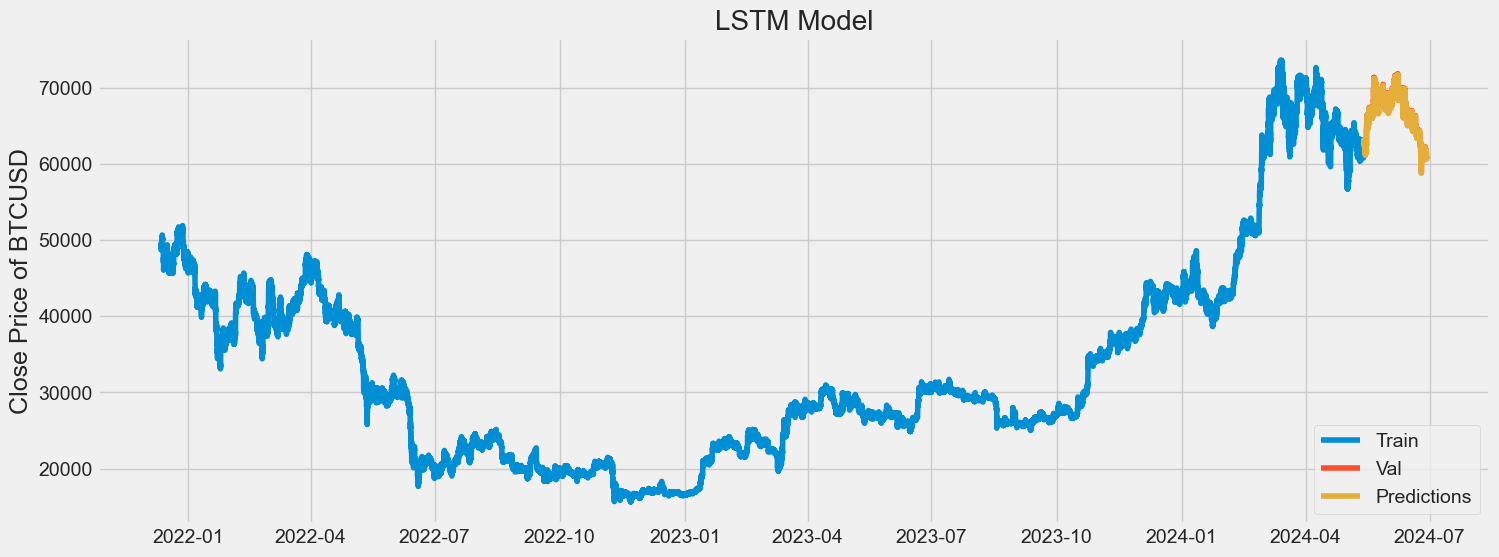

In [12]:
# Splitting the data
train = data[:training_data_len]
valid = data[training_data_len:]

# Setting predictions using .loc to avoid SettingWithCopyWarning
valid.loc[:, "Predictions"] = predictions

# Visualizing the data
plt.figure(figsize=(16,6))
plt.title("LSTM Model")
# plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price of BTCUSD", fontsize=18)
plt.plot(train["close"])
plt.plot(valid[["close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="lower right")
plt.show()

In [13]:
# Actual close Price and Prediction Price
valid

,close,Predictions
time,,
2024-05-13 15:00:00,62617.49,62655.667969
2024-05-13 15:15:00,62739.08,62555.183594
2024-05-13 15:30:00,62731.95,62677.035156
2024-05-13 15:45:00,62826.35,62665.820312
2024-05-13 16:00:00,62871.67,62763.519531
...,...,...
2024-06-28 18:15:00,60896.85,60678.562500
2024-06-28 18:30:00,60829.90,60869.839844
2024-06-28 18:45:00,60926.64,60793.027344


In [14]:
# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,859 (1.35 MB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,240 (918.91 KB)

### Saving and Loading the Model

In [15]:
# Save the model in keras format
model.save('./saved_model/model_v3.keras')

loaded_model_keras = models.load_model('./saved_model/model_v3.keras')